In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle
import pandas as pd

from sceb.util import *
import sceb.data_loader as dl
import sceb.scdd as sd
import sceb.scdd_extra as sde
import scanpy.api as sc

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import the data

In [2]:
input_folder = '/data/martin/single_cell/rna_fish_descend/'
file_dropseq = input_folder + 'dropseqFish.txt'
file_fish = input_folder + 'fishSubset.txt'
file_libsize = input_folder + 'libSize.txt'
df_fish = pd.read_table(file_fish, delimiter=' ')
df_dropseq = pd.read_table(file_dropseq, delimiter=' ')
df_dropseq = pd.DataFrame.transpose(df_dropseq)
df_libsize = pd.read_table(file_libsize, delimiter=' ')
gene_list = list(df_dropseq.columns)
n_gene = len(gene_list)
# Filter and normalize the fish data
fish_ind = np.array((df_fish['GAPDH']>100)&(df_fish['GAPDH']<1000), dtype=bool)
df_fish = df_fish[fish_ind]
# Filter the dropseq data
dropseq_ind = np.array(df_libsize[:]>1000, dtype=bool)
n_cell = np.sum(dropseq_ind)
df_dropseq = df_dropseq[dropseq_ind]
df_libsize = df_libsize[dropseq_ind]
output_folder = '/home/martin/single_cell_eb/figures/figure_smfish'

## Consistency between Dropseq and rnaFISH

In [3]:
# Estimation for Dropseq
ann_dropseq = sc.AnnData(df_dropseq)
ann_dropseq.X = scipy.sparse.csr_matrix(ann_dropseq.X)
size_factor = np.array(df_libsize/np.mean(df_libsize)).reshape([-1])
# CV
cv_dropseq_ml = np.zeros([n_gene], dtype=float)
cv_dropseq_dd = np.zeros([n_gene], dtype=float)
size_factor = np.array(df_libsize/np.mean(df_libsize)).reshape([-1])
for i_gene,gene in enumerate(gene_list):
    temp = df_dropseq[gene].as_matrix()
    cv_dropseq_ml[i_gene],cv_dropseq_dd[i_gene] = sde.cv_single(temp, size_factor=size_factor)
p0_dropseq_ml,p0_dropseq_dd = sd.dd_inactive_prob(ann_dropseq,
                                                  size_factor=size_factor,relative_depth=0.4)
# Bad genes 
gene_list = list(ann_dropseq.var_names)
n_gene = len(gene_list)
ind_bad = p0_dropseq_ml>0.97
for i_gene,gene in enumerate(gene_list):
    if gene in ['FOSL1', 'GAPDH']:
        ind_bad[i_gene] = True

# time start: 0.0s
n_cell=5763, n_gene=26
# total time: 0.2s


/home/martin/single_cell_eb/sceb/scdd_extra.py:220: RuntimeWarning: invalid value encountered in double_scalars
  cv_ml = np.std(Y_ml) / np.mean(Y_ml)
/home/martin/single_cell_eb/sceb/scdd_extra.py:225: RuntimeWarning: invalid value encountered in double_scalars
  cv_dd = np.sqrt(var_)/mean_


In [44]:
# Estimation for rnaFISH
size_factor_fish = np.array(df_fish['GAPDH'])
size_factor_fish = size_factor_fish / np.mean(size_factor_fish)
X_fish = df_fish.as_matrix()
cv_fish = np.zeros([n_gene], dtype=float)
p0_fish = np.zeros([n_gene], dtype=float)-1
for i_gene,gene in enumerate(gene_list):
    # CV estimation
    temp = X_fish[:, i_gene]
    ind_select = ~np.isnan(temp)
    temp = temp[ind_select]
    temp_size = size_factor_fish[ind_select]
    cv_fish[i_gene] = sde.cv_single_fish(temp, size_factor=temp_size)
    # Inactive probability with 2x deeper sequencing than Dropseq
    Y_dropseq = np.array(df_dropseq[gene], dtype=int)
    if temp.shape[0] < n_cell:
        continue
    temp_sub,_,success_flag = sde.subsample_single_gene(temp, n_cell, 
                                                        int(Y_dropseq.sum()*2.5),
                                                        random_state=0)
    if success_flag:
        p0_fish[i_gene] = np.mean(temp_sub==0)
    

not enough reads! 
VCL 4691


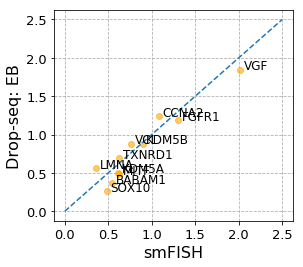

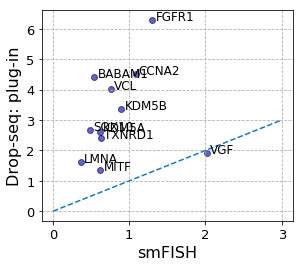

In [10]:
plt.figure(figsize=[4.5,4])
# plt.subplot(121)
plt.scatter(cv_fish[~ind_bad], cv_dropseq_dd[~ind_bad], color='orange', alpha=0.6)
plt.plot([0,2.5],[0,2.5], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: EB')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_dd[i]), fontsize=12)
#         plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_dd[i]), fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_dropseq_eb.pdf')
plt.show()

plt.figure(figsize=[4.5,4])
plt.scatter(cv_fish[~ind_bad], cv_dropseq_ml[~ind_bad], color='navy', alpha=0.6)
plt.plot([0,3],[0,3], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: plug-in')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (cv_fish[i]+0.04, cv_dropseq_ml[i]), fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_dropseq_plugin.pdf')
plt.show()

In [33]:
for i_gene,gene in enumerate(gene_list):
    print(i_gene,gene)

0 EGFR
1 SOX10
2 CCNA2
3 GAPDH
4 WNT5A
5 PDGFRB
6 PDGFC
7 SERPINE1
8 NGFR
9 NRG1
10 FOSL1
11 VEGFC
12 AXL
13 MITF
14 LOXL2
15 RUNX2
16 FGFR1
17 JUN
18 VGF
19 BABAM1
20 KDM5A
21 LMNA
22 KDM5B
23 C1S
24 VCL
25 TXNRD1


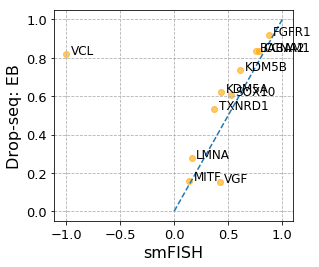

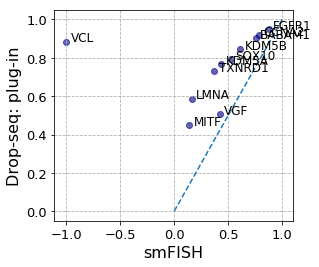

In [21]:
plt.figure(figsize=[4.5,4])
# plt.subplot(121)
plt.scatter(p0_fish[~ind_bad], p0_dropseq_dd[~ind_bad], color='orange', alpha=0.6)
# plt.scatter(cv_fish[ind_bad], cv_dropseq[ind_bad])
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: EB')
plt.xlim([0,1])
plt.ylim([0,1])
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (p0_fish[i]+0.04, p0_dropseq_dd[i]), fontsize=12)
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/p0_dropseq_eb.pdf')
# plt.subplot(122)
plt.figure(figsize=[4.5,4])
plt.scatter(p0_fish[~ind_bad], p0_dropseq_ml[~ind_bad], color='navy', alpha=0.6)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('smFISH')
plt.ylabel('Drop-seq: plug-in')
for i in range(n_gene):
    if ~ind_bad[i]:
        plt.annotate(gene_list[i], (p0_fish[i]+0.04, p0_dropseq_ml[i]), fontsize=12)
# plt.suptitle('inactive probability $\kappa=2$')
plt.tight_layout()
plt.grid(linestyle='--')
plt.savefig(output_folder + '/p0_dropseq_plugin.pdf')
plt.show()

## Subsampling experiment

In [14]:
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad[i_gene]:
        print('%s, mean_ds=%0.3f, cv_df=%0.3f, cv_fish=%0.3f'%
              (gene, df_dropseq[gene].mean(), cv_dropseq_dd[i_gene], cv_fish[i_gene]))

SOX10, mean_ds=0.298, cv_df=0.261, cv_fish=0.487
CCNA2, mean_ds=0.114, cv_df=1.242, cv_fish=1.085
MITF, mean_ds=1.554, cv_df=0.483, cv_fish=0.623
FGFR1, mean_ds=0.060, cv_df=1.190, cv_fish=1.305
VGF, mean_ds=2.353, cv_df=1.847, cv_fish=2.018
BABAM1, mean_ds=0.116, cv_df=0.362, cv_fish=0.544
KDM5A, mean_ds=0.403, cv_df=0.503, cv_fish=0.613
LMNA, mean_ds=0.979, cv_df=0.564, cv_fish=0.363
KDM5B, mean_ds=0.238, cv_df=0.883, cv_fish=0.897
VCL, mean_ds=0.168, cv_df=0.882, cv_fish=0.764
TXNRD1, mean_ds=0.508, cv_df=0.694, cv_fish=0.625


In [15]:
cv_fish_dic = {}
cv_dropseq_dic = {}
for i_gene,gene in enumerate(gene_list):
    cv_fish_dic[gene] = cv_fish[i_gene]
    cv_dropseq_dic[gene] = cv_dropseq_dd[i_gene]
exp_list = ['VGF', 'MITF'] 
res_cv = {}
for gene in exp_list:
    Y_gene = np.array(df_dropseq[gene])
    B_list = [300, 500, 800]
    res_cv[gene] = sde.simulate_tradeoff_cv_single(Y_gene, gene, B_list,
                                                   size_factor, n_rep=5000)

VGF Nr_bar=2.353
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500, Nr_bar_new=0.088
B=500, Nr_bar_new=0.115
B=500, Nr_bar_new=0.151
B=500, Nr_bar_new=0.197
B=500, Nr_bar_new=0.259
B=500, Nr_bar_new=0.339
B=500, Nr_bar_new=0.444
B=500, Nr_bar_new=0.582
B=500, Nr_bar_new=0.763
B=500, Nr_bar_new=1.000
B=800, Nr_bar_new=0.140
B=800, Nr_bar_new=0.174
B=800, Nr_bar_new=0.217
B=800, Nr_bar_new=0.270
B=800, Nr_bar_new=0.336
B=800, Nr_bar_new=0.418
B=800, Nr_bar_new=0.520
B=800, Nr_bar_new=0.646
B=800, Nr_bar_new=0.804
B=800, Nr_bar_new=1.000
MITF Nr_bar=1.554
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500

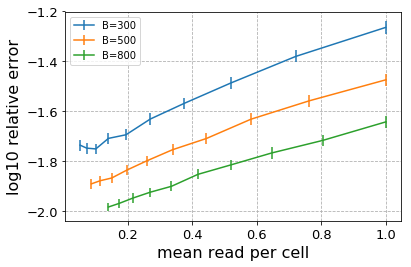

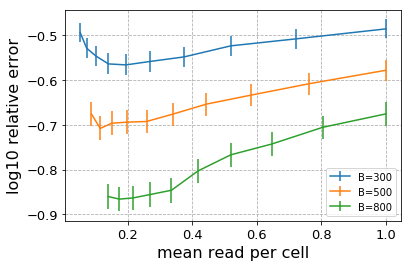

In [16]:
# for gene in exp_list:
for gene in exp_list:
    temp_res = res_cv[gene]
    B_list = list(temp_res.keys())
    plt.figure()
    for B in B_list:
        cv_ml = temp_res[B]['cv_ml']
        cv_dd = temp_res[B]['cv_dd']
        Nr_bar_new_list = temp_res[B]['Nr_bar_new_list']
        error_dd = (cv_dd - cv_fish_dic[gene])**2 / (cv_fish_dic[gene]**2)
#         error_dd = (cv_dd - cv_dropseq_dic[gene])**2 / (cv_dropseq_dic[gene]**2)
        mean_err = np.nanmean(error_dd, axis=0)
        std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        
        plt.errorbar(Nr_bar_new_list, y_val, y_err*3, label='B=%d'%(B))
    plt.xlabel('mean read per cell')
    plt.ylabel('log10 relative error')
    plt.legend()
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder + '/cv_tradeoff_%s.pdf'%gene)
    plt.show()

In [17]:
exp_list = ['VGF', 'MITF'] 
# exp_list = ['VGF'] 
res_p0 = {}
for gene in exp_list:
    Y_gene = np.array(df_dropseq[gene])
    B_list = [300, 500, 800]
    res_p0[gene] = sde.simulate_tradeoff_p0_single(Y_gene, gene, B_list,
                                                   size_factor, n_rep=200)

VGF Nr_bar=2.353
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500, Nr_bar_new=0.088
B=500, Nr_bar_new=0.115
B=500, Nr_bar_new=0.151
B=500, Nr_bar_new=0.197
B=500, Nr_bar_new=0.259
B=500, Nr_bar_new=0.339
B=500, Nr_bar_new=0.444
B=500, Nr_bar_new=0.582
B=500, Nr_bar_new=0.763
B=500, Nr_bar_new=1.000
B=800, Nr_bar_new=0.140
B=800, Nr_bar_new=0.174
B=800, Nr_bar_new=0.217
B=800, Nr_bar_new=0.270
B=800, Nr_bar_new=0.336
B=800, Nr_bar_new=0.418
B=800, Nr_bar_new=0.520
B=800, Nr_bar_new=0.646
B=800, Nr_bar_new=0.804
B=800, Nr_bar_new=1.000
MITF Nr_bar=1.554
B=300, Nr_bar_new=0.053
B=300, Nr_bar_new=0.073
B=300, Nr_bar_new=0.101
B=300, Nr_bar_new=0.140
B=300, Nr_bar_new=0.195
B=300, Nr_bar_new=0.270
B=300, Nr_bar_new=0.375
B=300, Nr_bar_new=0.520
B=300, Nr_bar_new=0.721
B=300, Nr_bar_new=1.000
B=500

In [18]:
p0_fish_dic = {}
np.random.seed(0)
for gene in exp_list:
    temp = np.array(df_fish[gene])
    ind_select = ~np.isnan(temp)
    temp = temp[ind_select]
    temp_sub,_,success_flag = sde.subsample_single_gene(temp, n_cell, 
                                                        int(n_cell),
                                                        random_state=0)
    if success_flag:
        p0_fish_dic[gene] = np.mean(temp_sub==0)

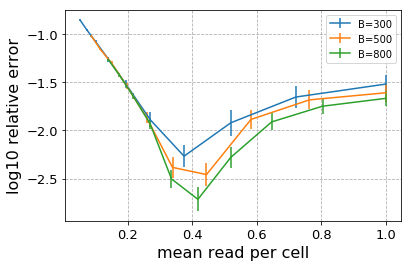

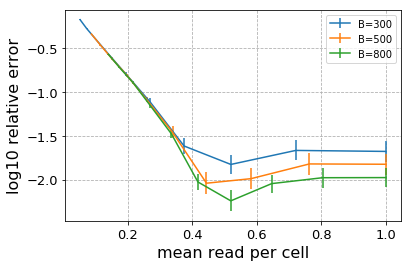

In [19]:
# for gene in exp_list:
for gene in exp_list:
    temp_res = res_p0[gene]
    B_list = list(temp_res.keys())
    plt.figure()
    for B in B_list:
        p0_ml = temp_res[B]['p0_ml']
        p0_dd = temp_res[B]['p0_dd']
        Nr_bar_new_list = temp_res[B]['Nr_bar_new_list']
        error_dd = (p0_dd - p0_fish_dic[gene])**2 / (p0_fish_dic[gene]**2)
#         error_dd = (cv_dd - cv_dropseq_dic[gene])**2 / (cv_dropseq_dic[gene]**2)
        mean_err = np.nanmean(error_dd, axis=0)
        std_err = np.nanstd(error_dd, axis=0) / np.sqrt(np.sum(~np.isnan(error_dd), axis=0))
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        
        plt.errorbar(Nr_bar_new_list, y_val, y_err*3, label='B=%d'%(B))
    plt.xlabel('mean read per cell')
    plt.ylabel('log10 relative error')
    plt.legend()
    plt.grid(linestyle='--')
    plt.tight_layout()
    plt.savefig(output_folder + '/p0_tradeoff_%s.pdf'%gene)
    plt.show()

# debug

In [ ]:
# PC 
PC_ml = np.zeros([n_gene, n_gene], dtype=float)
PC_dd = np.zeros([n_gene, n_gene], dtype=float)
for i_gene,gene1 in enumerate(gene_list):
    for j_gene,gene2 in enumerate(gene_list):
        temp1 = df_dropseq[gene1].as_matrix()
        temp2 = df_dropseq[gene2].as_matrix()
        res = sde.PC_single(temp1, temp2, size_factor=size_factor)
        PC_ml[i_gene, j_gene] = res[0]
        PC_dd[i_gene, j_gene] = res[1]# Inactive probability


In [ ]:

# Pearson correlation estimation
data_available = np.ones([n_gene, n_gene], dtype=bool)
X_fish = df_fish.as_matrix()
PC_fish = np.zeros([n_gene, n_gene], dtype=float)-2
for i_gene,gene1 in enumerate(gene_list):
    for j_gene,gene2 in enumerate(gene_list):
        ind_select = (~np.isnan(X_fish[:, i_gene]))&(~np.isnan(X_fish[:, j_gene]))
        if np.sum(ind_select)==0:
            data_available[i_gene, j_gene] = False
            data_available[j_gene, i_gene] = False
            continue
        temp1 = X_fish[ind_select, i_gene]
        temp2 = X_fish[ind_select, j_gene]
        temp_size = size_factor_fish[ind_select]
        PC_fish[i_gene,j_gene] = sde.PC_single_fish(temp1, temp2, size_factor=temp_size)

In [ ]:
n_cell,n_gene = df_dropseq.shape
## subsample experiment
exp_list = ['VGF', 'MITF', 'LMNA', 'TXNRD1']
# exp_list = ['VGF']
# B = 250
B_list = [200, 300, 400]
# Nr_bar_new_list = np.linspace(0.2, 1.2, 11)
# Nr_bar_new_list = [0.05, 0.1, 0.2, 0.5, 1]
n_param = 10
n_rep = 1000
res = {}
error_dic_fish = {}
error_dic_dropseq = {}
cv_hat_dic = {}
for gene in exp_list:
    Y_gene = np.array(df_dropseq[gene])
    print(gene, 'Nr_bar=%0.3f'%(np.mean(Y_gene)))
    res[gene] = {}    
    for B in B_list:
        res[gene][B] = {}
        Nr_bar_new_lb = 1.05*B/n_cell
        Nr_bar_new_ub = min(0.7*np.mean(Y_gene), 1)
        Nr_bar_new_list = np.exp(np.linspace(np.log(Nr_bar_new_lb),
                                             np.log(Nr_bar_new_ub), n_param))
        n_param = Nr_bar_new_list.shape[0]
        res[gene][B]['cv_hat'] = np.zeros([n_rep, n_param])
        res[gene][B]['error_fish'] = np.zeros([n_rep, n_param])
        res[gene][B]['error_dropseq'] = np.zeros([n_rep, n_param])
        res[gene][B]['Nr_bar_new_list'] = Nr_bar_new_list
        for i_param,Nr_bar_new in enumerate(Nr_bar_new_list):
            print('B=%d, Nr_bar_new=%0.3f'%(B,Nr_bar_new))
            Nc_new = int(B/Nr_bar_new)
            for i_rep in range(n_rep): 
                Y_new, ind_cell, flag = sde.subsample_single_gene(Y_gene, Nc_new,\
                                                                  B, random_state=i_rep)
                if flag is False:
                    Y_new, ind_cell, flag = sde.subsample_single_gene(Y_gene, Nc_new,\
                                                                      B, random_state=i_rep+n_rep)
                size_factor_new = size_factor[ind_cell]
                M1 = np.mean(Y_new) / np.mean(size_factor_new)
                M2 = (np.mean(Y_new**2) - np.mean(Y_new)) / np.mean(size_factor_new**2)
                cv_hat = np.sqrt((M2-M1**2).clip(min=0)) / M1
                res[gene][B]['cv_hat'][i_rep, i_param] = cv_hat
                res[gene][B]['error_fish'][i_rep, i_param] = (cv_fish_dic[gene]-cv_hat)**2
                res[gene][B]['error_dropseq'][i_rep, i_param] = (cv_dropseq_dic[gene]-cv_hat)**2    
#             error_dic_fish[gene][i_rep, i_param] = np.absolute(cv_fish_dic[gene]-cv_hat)
#             error_dic_dropseq[gene][i_rep, i_param] = np.absolute(cv_dropseq_dic[gene]-cv_hat)  

In [53]:
for i_gene in range(n_gene):
    for j_gene in range(i_gene+1,n_gene):
        if ~ind_bad[i_gene] & ~ind_bad[j_gene] & data_available[i_gene, j_gene]:
            gene_pair = gene_list[i_gene]+'-'+gene_list[j_gene]
            print('%s, %d, %d, %0.4f, %0.4f, PC_fish = %0.4f, PC_dropseq = %0.4f'
                  %(gene_pair, i_gene, j_gene, M_ml[0, i_gene], M_ml[0, j_gene], PC_fish[i_gene, j_gene], PC_dd[i_gene, j_gene]))

SOX10-CCNA2, 1, 2, 0.3076, 0.1239, PC_fish = 0.2724, PC_dropseq = 0.0228
SOX10-MITF, 1, 13, 0.3076, 1.6381, PC_fish = 0.1129, PC_dropseq = -0.1764
SOX10-FGFR1, 1, 16, 0.3076, 0.0578, PC_fish = -0.5309, PC_dropseq = -0.4198
SOX10-VGF, 1, 18, 0.3076, 2.1084, PC_fish = -0.3592, PC_dropseq = 0.1754
CCNA2-MITF, 2, 13, 0.1239, 1.6381, PC_fish = -0.0697, PC_dropseq = 0.3644
CCNA2-FGFR1, 2, 16, 0.1239, 0.0578, PC_fish = -0.1977, PC_dropseq = -0.0015
CCNA2-VGF, 2, 18, 0.1239, 2.1084, PC_fish = -0.1679, PC_dropseq = -0.0065
MITF-FGFR1, 13, 16, 1.6381, 0.0578, PC_fish = -0.1572, PC_dropseq = -0.0676
MITF-VGF, 13, 18, 1.6381, 2.1084, PC_fish = -0.0668, PC_dropseq = -0.0276
FGFR1-VGF, 16, 18, 0.0578, 2.1084, PC_fish = 0.2913, PC_dropseq = 0.0905
BABAM1-KDM5A, 19, 20, 0.1136, 0.3955, PC_fish = 0.5877, PC_dropseq = -0.7016
BABAM1-LMNA, 19, 21, 0.1136, 0.8687, PC_fish = 0.4734, PC_dropseq = -0.0153
KDM5A-LMNA, 20, 21, 0.3955, 0.8687, PC_fish = 0.2198, PC_dropseq = -0.2431
LMNA-KDM5B, 21, 22, 0.8687, 0

In [ ]:
gene = 'VGF'
Y_fish = np.array(df_fish[gene])
Y_fish = Y_fish[~np.isnan(Y_fish)]
Y_fish = np.array(Y_fish, dtype=int)
Y_dropseq = np.array(df_dropseq[gene], dtype=int)
Y_fish_sub,_,_ =  subsample_single_gene(Y_fish, 5763, 8957, random_state=0)
print('Total reads: fish=%d, dropseq=%d'%(Y_fish.sum(),Y_dropseq.sum()))
print('Mean reads: fish=%0.2f, dropseq=%0.2f'%(Y_fish.mean(),Y_dropseq.mean()))
print('cv_sub=%0.3f, cv_dropseq=%0.3f'%(np.std(Y_fish_sub)/np.mean(Y_fish_sub),\
                                        np.std(Y_dropseq)/np.mean(Y_dropseq)))
bins = np.arange(100)-0.5
plt.figure()
plt.hist(Y_fish, bins=bins, alpha=0.4, label='fish')
plt.hist(Y_fish_sub, bins=bins, alpha=0.4, label='fish_sub')
plt.hist(Y_dropseq, bins=bins, alpha=0.4, label='drop_seq')
plt.xlim([0,50])
plt.legend()
plt.show()

In [ ]:
plt.figure()
for gene in exp_list:
    error_rec = error_dic_fish[gene]
    mean_err = np.nanmean(error_rec, axis=0)
    std_err = np.nanstd(error_rec, axis=0) / np.sqrt(n_rep)
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
    plt.errorbar(Nr_bar_new_list, y_val, y_err, label=gene)
plt.legend()
plt.show()

plt.figure()
for gene in exp_list:
    error_rec = error_dic_dropseq[gene]
    mean_err = np.nanmean(error_rec, axis=0)
    std_err = np.nanstd(error_rec, axis=0) / np.sqrt(n_rep)
    y_val = np.log10(mean_err)
    y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
    plt.errorbar(Nr_bar_new_list, y_val, y_err, label=gene)

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[5,5])
plt.scatter(p0_fish[~ind_bad], p0_dd[~ind_bad])
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('fish')
plt.ylabel('dropseq')
plt.show()
plt.figure(figsize=[5,5])
plt.scatter(p0_fish[~ind_bad], p0_ml[~ind_bad])
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('fish')
plt.ylabel('dropseq')
plt.show()

In [ ]:
## subsample experiment
exp_list = ['LMNA','MITF']
exp_ind = np.zeros([len(gene_list)], dtype=bool)
for i_gene,gene in enumerate(gene_list):
    if gene in exp_list:
        exp_ind[i_gene] = True
data = ann_dropseq[:, exp_list]
print(data.X.sum(axis=0))
Nc,G,Nr,Nr_bar = sd.get_info(data)
B = 1000
Nr_bar_new_list = np.linspace(0.2, 1.2, 11)
n_param = len(Nr_bar_new_list)
n_rep = 500
error_rec = np.zeros([n_rep, n_param])
cv_true = cv_dropseq[exp_ind]
for i_param,Nr_bar_new in enumerate(Nr_bar_new_list):
    Nr_new = Nr_bar_new*G
    Nc_new = int(B/Nr_bar_new)
    print(Nc_new, Nr_bar_new, Nr_new)
    for i_rep in range(n_rep):        
        data_new = sd.subsample_anndata(data,Nr_new,Nc_new,random_state=i_rep,verbose=False)
        size_factor_new = np.zeros([Nc_new])
        for i_obs,obs in enumerate(data_new.obs_names):
            size_factor_new[i_obs] = size_factor_dic[obs]
        M_ml, M_dd = sd.dd_1d_moment(data_new, size_factor=size_factor_new,\
                                     verbose=False)
        cv = sd.M_to_cv(M_dd)
#         print(cv, cv_true)
        error_rec[i_rep, i_param] = np.linalg.norm(cv-cv_true)

In [ ]:
gene = 'MITF'
Y_gene = np.array(df_dropseq[gene])
plt.figure()
plt.hist(cv_hat_dic[gene][:,1] - cv_fish_dic[gene], bins=20, alpha=0.4)
plt.hist(cv_hat_dic[gene][:,3] - cv_fish_dic[gene], bins=20, alpha=0.4)
plt.show()
plt.figure()
plt.hist(Y_gene[Y_gene>0], bins=20)
plt.show()

In [ ]:
for gene in exp_list:
    plt.figure()
    for B in B_list:
        error_rec = res[gene][B]['error_fish']
#         error_rec = res[gene][B]['error_dropseq']
#         error_rec = (res[gene][B]['cv_hat'] - cv_hat
#         error_rec = res[gene][B]['error_dropseq']
        Nr_bar_new_list = res[gene][B]['Nr_bar_new_list']
        mean_err = np.nanmean(error_rec, axis=0)
        std_err = np.nanstd(error_rec, axis=0) / np.sqrt(n_rep)
        y_val = np.log10(mean_err)
        y_err = np.log10(mean_err+std_err) - np.log10(mean_err)
        plt.errorbar(Nr_bar_new_list, y_val, y_err, label='%s, B=%d'%(gene,B))
    plt.legend()
    plt.show()

In [ ]:
plt.figure(figsize=[12,5])
plt.suptitle('Pearson correlation')
plt.subplot(121)
for i_gene in range(n_gene):
    for j_gene in range(i_gene+1,n_gene):
        if ~ind_bad[i_gene] & ~ind_bad[j_gene]:
            
            plt.scatter(PC_fish[i_gene, j_gene], PC_dd[i_gene, j_gene],
                        color='steelblue')
            gene_pair = gene_list[i_gene]+'-'+gene_list[j_gene]
            plt.annotate(gene_pair, (PC_fish[i_gene, j_gene]+0.04,
                                     PC_dd[i_gene, j_gene]), fontsize=10)
plt.plot([-1,1],[-1,1], linestyle='--')
plt.xlim([-1,1])
plt.ylabel('dropseq: EB')
plt.xlabel('fish')
plt.subplot(122)
for i_gene in range(n_gene):
    for j_gene in range(i_gene+1,n_gene):
        if ~ind_bad[i_gene] & ~ind_bad[j_gene] & (PC_fish[i_gene, j_gene]!=-2):
            plt.scatter(PC_fish[i_gene, j_gene], PC_ml[i_gene, j_gene],
                        color='steelblue')
            gene_pair = gene_list[i_gene]+'-'+gene_list[j_gene]
            plt.annotate(gene_pair, (PC_fish[i_gene, j_gene]+0.04,
                                     PC_ml[i_gene, j_gene]), fontsize=6)
plt.plot([-1,1],[-1,1], linestyle='--')
plt.ylabel('dropseq: plug-in')
plt.xlabel('fish')
plt.tight_layout()
plt.show()